In [104]:
import matplotlib 
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [105]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [106]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [107]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [108]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [109]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [110]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [111]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [112]:
# Find the most recent date in the data set.
# for row in session.query(Measurement.date).limit(1).all():
#     print(row)

session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [119]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date).first()

# Calculate the date one year from the last date in data set.
most_recent = session.query(Measurement.date).order_by((Measurement.date.desc())).first()
most_recent_date = dt.datetime.strptime(most_recent[0], '%Y-%m-%d')

                # last_date is '2017-08-23'
one_yr_ago = most_recent_date - dt.timedelta(days=365)
one_yr_ago

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_yr_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
# df.set_index('Date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('Date')
df

df_clean = df.dropna(subset=['Precipitation'])
df_clean['Date'] = pd.to_datetime(df['Date'])
df_clean

# Use Pandas Plotting with Matplotlib to plot the data
df_clean.boxplot(column = 'Precipitation', by = 'Date',  figsize=(12, 6))
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()


C:\Users\nwf91\AppData\Local\Temp\ipykernel_760\2117551938.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df['Date'])


KeyError: 'date'

In [114]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = df_clean['Precipitation'].describe()
print(sum_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [115]:
# Design a query to calculate the total number of stations in the dataset
# session.query(Station.station).all()
session.query(Station.station).count()
# count = session.query(Station).count()


9

In [116]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [117]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
high_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
    
print(f"For station USC00519281, the lowest temp is {low_temp}, the highest temp is {high_temp}, the average temp is {avg_temp}")


For station USC00519281, the lowest temp is 54.0, the highest temp is 85.0, the average temp is 71.66378066378067


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


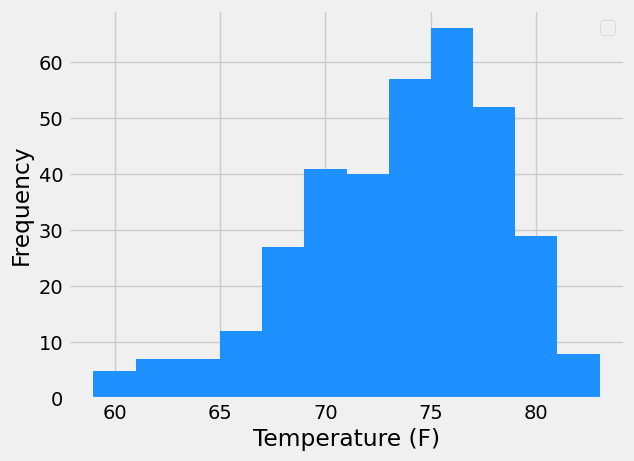

In [118]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= one_yr_ago).all()

df = pd.DataFrame(results, columns = ['Date', 'Temperature'])

plt.hist(df['Temperature'], bins=12, color='dodgerblue')
plt.legend()
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [103]:
# Close Session
session.close()